In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'BaselineV1'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_deepsig_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 36)             9252      
_________________________________________________________________
dense (Dense)                (None, 2, 256)            9472      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 18)             18450     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 18)             0         
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4864  

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100
162/162 [==============================] - 12s 9ms/step - loss: 2.2922 - val_loss: 2.1199
Epoch 2/100
162/162 [==============================] - 1s 6ms/step - loss: 2.1009 - val_loss: 2.0794
Epoch 3/100
162/162 [==============================] - 1s 6ms/step - loss: 2.0583 - val_loss: 2.0011
Epoch 4/100
162/162 [==============================] - 1s 6ms/step - loss: 1.9651 - val_loss: 1.9198
Epoch 5/100
162/162 [==============================] - 1s 6ms/step - loss: 1.8960 - val_loss: 1.8797
Epoch 6/100
162/162 [==============================] - 1s 6ms/step - loss: 1.8612 - val_loss: 1.8433
Epoch 7/100
162/162 [==============================] - 1s 6ms/step - loss: 1.8100 - val_loss: 1.7838
Epoch 8/100
162/162 [==============================] - 1s 6ms/step - loss: 1.7623 - val_loss: 1.7427
Epoch 9/100
162/162 [==============================] - 1s 6ms/step - loss: 1.7191 - val_loss: 1.7281
Epoch 10/100
162/162 [==============================] - 1s 6ms/step - loss: 1.7013 - val_l

# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 0s 3ms/step - loss: 1.4373
1.437294602394104


## Loss

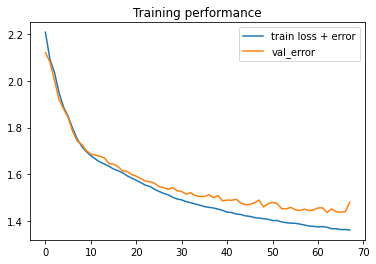

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

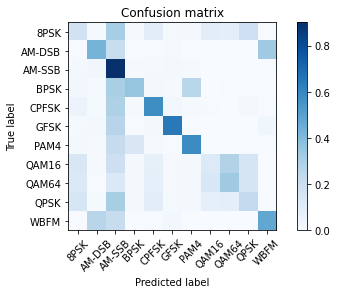

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09063893016344725
Overall Accuracy:  0.10166358595194085
Overall Accuracy:  0.09367267585719335
Overall Accuracy:  0.11595221363316936
Overall Accuracy:  0.1398121387283237
Overall Accuracy:  0.19656283566058003
Overall Accuracy:  0.29415979935506986
Overall Accuracy:  0.3862645348837209
Overall Accuracy:  0.4728434504792332
Overall Accuracy:  0.5913012221423436
Overall Accuracy:  0.6350762527233116
Overall Accuracy:  0.6476739992787595
Overall Accuracy:  0.6314990512333966
Overall Accuracy:  0.6421641791044777
Overall Accuracy:  0.6156340057636888
Overall Accuracy:  0.6347065257017863
Overall Accuracy:  0.6268048870788597
Overall Accuracy:  0.6299360661902971
Overall Accuracy:  0.6215917464996316
Overall Accuracy:  0.6290322580645161


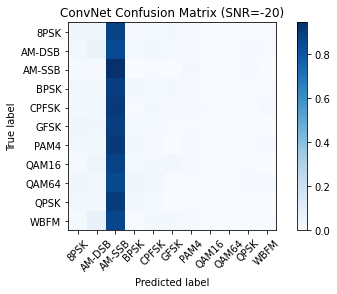

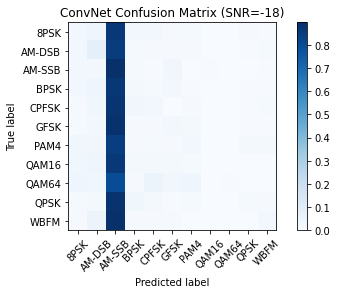

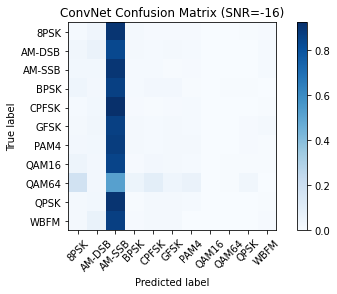

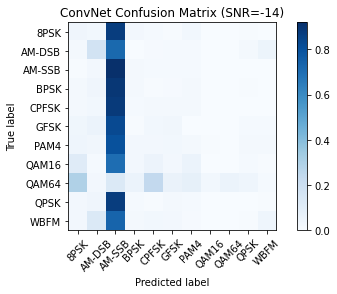

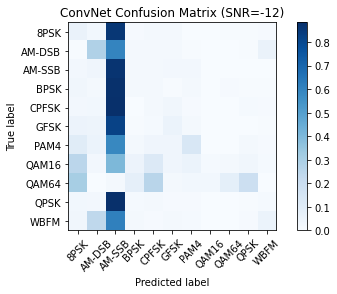

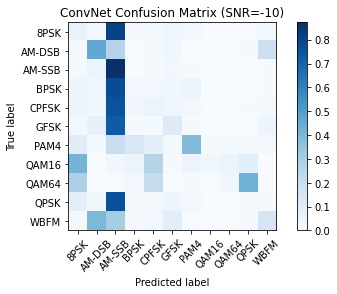

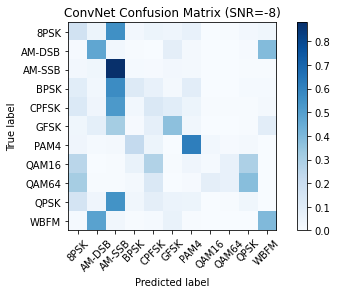

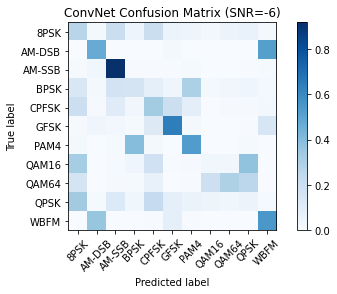

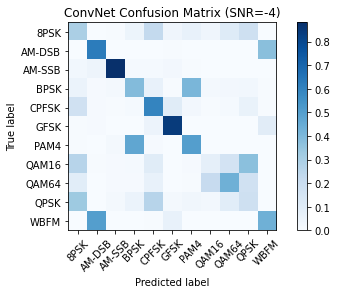

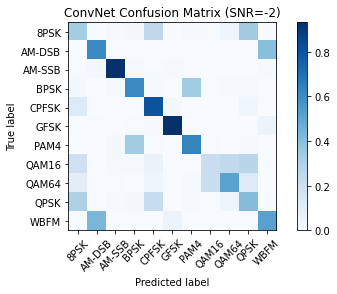

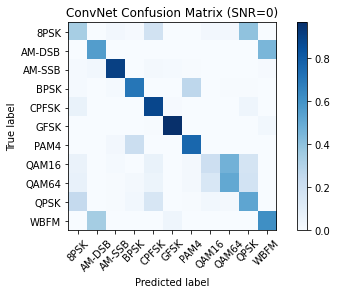

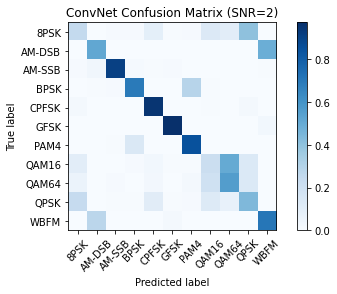

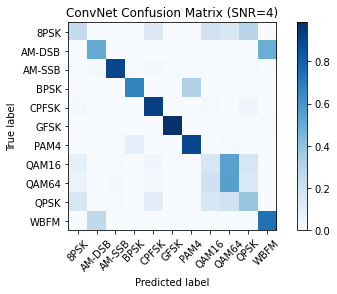

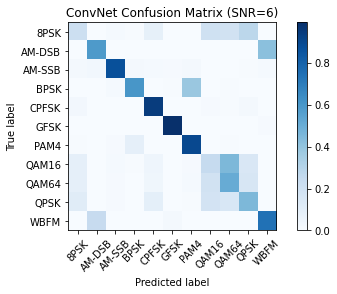

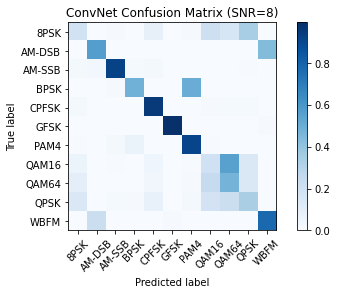

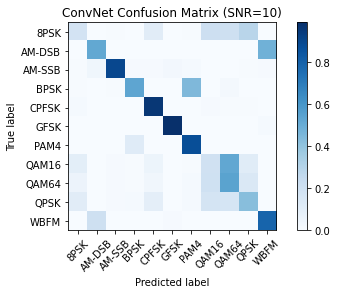

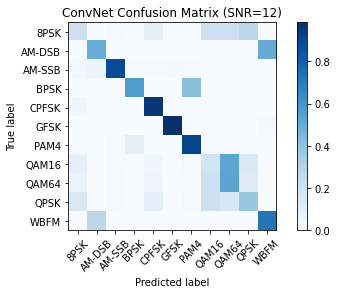

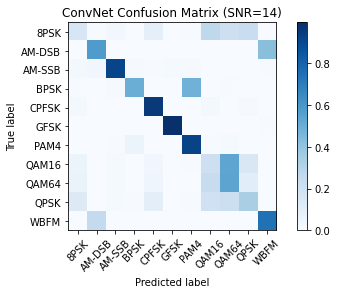

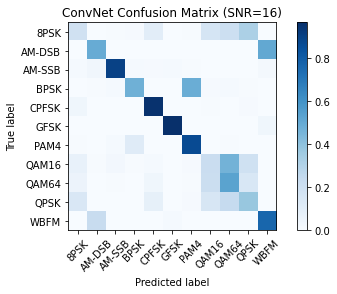

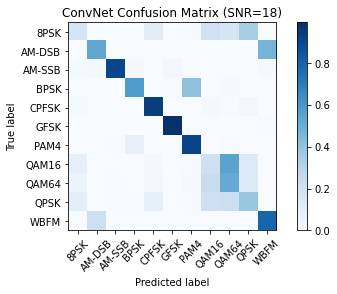

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,10,9,11,13,19,29,38,47,59,63,64,63,64,61,63,62,62,62,62


In [18]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )

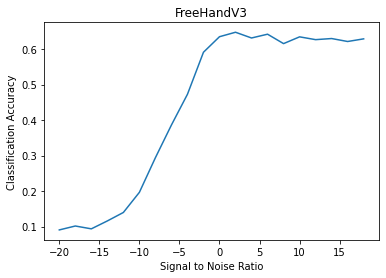

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)